In [1]:
import csv
from dataclasses import (dataclass, field, fields)
import matplotlib.pyplot as plt
import numpy as np
import re
import statistics

In [2]:
CSV_FILE_PATH = "../gitignore/cube_search/large_cube_2023_Aug_23_00_35_54_.csv"

In [3]:
@dataclass(frozen=True)
class TestPower:
    p_column: str = field(compare=False)
    t_column: str = field(compare=False, metadata={"dontparse": True})
    iterations: int
    trainingN: int
    testingN: int

In [4]:
headerparser = re.compile(r"(?P<p_column>test_(?P<iterations>\d+)_(?P<trainingN>\d+)_(?P<testingN>\d+)_p)")

In [5]:
def score (s : str) -> int:
    p = float(s)
    if 0.05 < p:
        return 2
    elif 0.01 < p:
        return 1
    else:
        return 0
    
def estimate_time(data, tp: TestPower, std_devs: int = 0):
    usedata = [float(d[tp][1]) for d in data]
    mean = statistics.mean(usedata)
    std_dev = statistics.stdev(usedata, xbar=mean)
    return mean + (std_devs * std_dev)

In [6]:
with open(CSV_FILE_PATH, 'r', newline="") as f:
    dr = csv.DictReader(f)
    test_powers = tuple(TestPower(t_column = match.group("p_column")[:-1] + "time",
                                  **{field.name: field.type(match.group(field.name))
                                     for field in fields(TestPower)
                                     if field.metadata.get("dontparse") is None})
                        for match in map(headerparser.fullmatch, dr.fieldnames)
                        if match is not None
                       )
    data = {row["filename"] : {tp : (score(row[tp.p_column]), row[tp.t_column])
                               for tp in test_powers}
            for row in dr}

p_scores = {tp : sum(d[tp][0] for d in data.values())
            for tp in test_powers}
high_times = {tp : estimate_time(data.values(), tp, std_devs=2)
              for tp in test_powers}


# 3D box surface plot

Given data on a gridded volume ``X``, ``Y``, ``Z``, this example plots the
data values on the volume surfaces.

The strategy is to select the data from each surface and plot
contours separately using `.axes3d.Axes3D.contourf` with appropriate
parameters *zdir* and *offset*.


In [7]:
# Define dimensions
iterations = frozenset(tp.iterations for tp in p_scores.keys())
trainingNs = frozenset(tp.trainingN for tp in p_scores.keys())
testingNs = frozenset(tp.testingN for tp in p_scores.keys())

X, Y, Z = np.meshgrid(sorted(iterations), sorted(trainingNs), sorted(testingNs))

data = None

p_data = np.array( [ [ [ p_scores.get(TestPower("", "", x, y, z), -10)
                         for x, y, z in zip(X_row, Y_row, Z_row) ]
                       for X_row, Y_row, Z_row in zip(X_frame, Y_frame, Z_frame) ]
                     for X_frame, Y_frame, Z_frame in zip(X, Y, Z) ]
                 )

t_data = np.array( [ [ [ high_times.get(TestPower("", "", x, y, z), -10)
                         for x, y, z in zip(X_row, Y_row, Z_row) ]
                       for X_row, Y_row, Z_row in zip(X_frame, Y_frame, Z_frame) ]
                     for X_frame, Y_frame, Z_frame in zip(X, Y, Z) ]
                 )
(p_data, t_data)

(array([[[ 70,  45,  36,  38,  25],
         [ 48,  30,  24,  22,  12],
         [ 32,  22,  13,  14,  11],
         [ 23,  17,   9,  11,   5],
         [ 15,  12,   8,   4,   5]],
 
        [[ 22,  15,  18,  14,  13],
         [ 18, -10, -10, -10,   6],
         [ 16, -10, -10, -10,   2],
         [  9, -10, -10, -10,   0],
         [  6,   4,   2,   2,   2]],
 
        [[ 21,  14,  11,   8,   8],
         [ 11, -10, -10, -10,   3],
         [ 12, -10, -10, -10,   0],
         [  6, -10, -10, -10,   2],
         [  3,   1,   2,   0,   0]],
 
        [[ 13,   7,   4,   4,   3],
         [  2, -10, -10, -10,   2],
         [  7, -10, -10, -10,   1],
         [  2, -10, -10, -10,   1],
         [  2,   2,   0,   0,   0]],
 
        [[ 13,   4,   3,   0,   0],
         [  4,   2,   1,   2,   1],
         [  2,   2,   2,   2,   1],
         [  1,   2,   2,   0,   1],
         [  2,   2,   0,   0,   0]]]),
 array([[[  3.52225773,   4.3381205 ,   5.0996179 ,   6.85116517,
            9.07860

In [32]:
p_kw = {
    'vmin': min(p_scores.values()),
    'vmax': max(p_scores.values()),
    #'levels': np.linspace(min(results.values()), max(results.values()), 10),
    'levels': np.array([-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 8.5, 12.5, 200]),
    'colors': ['white', 'lightgrey', 'grey', 'lightblue', 'blue', 'darkblue', 'darkred', 'red', 'fuchsia', 'black']
}
t_kw = {
    'vmin': 0,
    'vmax': t_data.max(),
    #'levels': np.linspace(min(results.values()), max(results.values()), 10),
    'levels': np.array([0, 1, 2, 3, 4, 5, 6, 12, 18, 24, 200])
}

xmin, xmax = X.min(), X.max()
ymin, ymax = Y.min(), Y.max()
zmin, zmax = Z.min(), Z.max()

edges_kw = dict(color=(0.0, 1.0, 0.0, 0.15), linewidth=1, zorder=1e3)

axes_set_kw = {'xlim': [xmin, xmax], 'ylim': [ymin, ymax], 'zlim': [zmin, zmax],
               'xlabel':'iterations', 'ylabel':'training', 'zlabel':'testimg'}

def configure_ax(ax, foreground):
    if foreground:
        for i in iterations:
            ax.plot([i, i], [ymin, ymax], [zmin, zmin], **edges_kw)
            ax.plot([i, i], [ymin, ymin], [zmin, zmax], **edges_kw)
        for t in trainingNs:
            ax.plot([xmin, xmax], [t, t], [zmin, zmin], **edges_kw)
            ax.plot([xmin, xmin], [t, t], [zmin, zmax], **edges_kw)
        for t in testingNs:
            ax.plot([xmin, xmax], [ymin, ymin], [t, t], **edges_kw)
            ax.plot([xmin, xmin], [ymin, ymax], [t, t], **edges_kw)
    else:
        for i in iterations:
            ax.plot([i, i], [ymin, ymax], [zmax, zmax], **edges_kw)
            ax.plot([i, i], [ymax, ymax], [zmin, zmax], **edges_kw)
        for t in trainingNs:
            ax.plot([xmin, xmax], [t, t], [zmax, zmax], **edges_kw)
            ax.plot([xmax, xmax], [t, t], [zmin, zmax], **edges_kw)
        for t in testingNs:
            ax.plot([xmin, xmax], [ymax, ymax], [t, t], **edges_kw)
            ax.plot([xmax, xmax], [ymin, ymax], [t, t], **edges_kw)
        
    ax.set(**axes_set_kw)
    ax.view_init(40, 30, 0)
    ax.set_box_aspect(None, zoom=0.9)



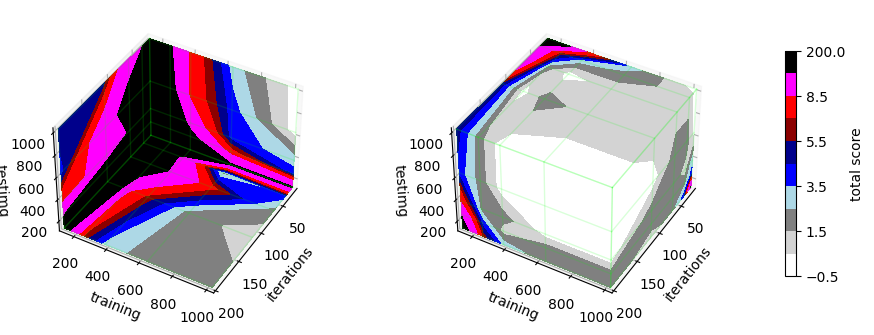

In [33]:
# Create a figure with 3D ax
fig = plt.figure(figsize=(16, 4))
ax1 = fig.add_subplot(111, projection='3d')

# Plot contour surfaces
_ = ax1.contourf(
    X[:, :, 0], Y[:, :, 0], p_data[:, :, 0],
    zdir='z', offset=Z.min(), **p_kw
)
_ = ax1.contourf(
    X[0, :, :], p_data[0, :, :], Z[0, :, :],
    zdir='y', offset=Y.min(), **p_kw
)
C = ax1.contourf(
    p_data[:, 0, :], Y[:, 0, :], Z[:, 0, :],
    zdir='x', offset=X.min(), **p_kw
)
# --
configure_ax(ax1, True)


ax2 = fig.add_subplot(122, projection='3d')

# Plot contour surfaces
_ = ax2.contourf(
    X[:, :, -1], Y[:, :, -1], p_data[:, :, -1],
    zdir='z', offset=Z.max(), **p_kw
)
_ = ax2.contourf(
    X[-1, :, :], p_data[-1, :, :], Z[-1, :, :],
    zdir='y', offset=Y.max(), **p_kw
)
C = ax2.contourf(
    p_data[:, -1, :], Y[:, -1, :], Z[:, -1, :],
    zdir='x', offset=X.max(), **p_kw
)
# --
configure_ax(ax2, False)

# Colorbar
fig.colorbar(C, ax=ax2, fraction=0.02, pad=0.1, label='total score')

# Show Figure
plt.show()

Each p-value > 0.05 contributes 2 to the total score, and each > 0.01 contributes 1; lower scores are better.

- Good results are impossible with sparse `training` data, regardless of other parameters.
- The number of `iterations` of the experiment does seem to have trade-offs with other parameters, but good results are possible even with very few iterations.
- I feel like the data is consistent with `testing` being of intermediate importance, but I'm steuggling to be more specific...